In [1]:
from SBM_SDE import *
from obs_and_flow_classes_and_functions import *
from get_CO2 import *
import torch
from torch import nn
import torch.distributions as d
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
from tqdm.notebook import tqdm
import random
from torch.autograd import Function
import argparse
import os
import sys
from pathlib import Path
import shutil
import pandas as pd

In [2]:
torch.manual_seed(0)
devi = torch.device("".join(["cuda:",f'{cuda_id}']) if torch.cuda.is_available() else "cpu")

cuda_id = 1
dt = 2 #SDE discretization timestep.
t = 100 #Simulation run for T hours.
n = int(t / dt) 
t_span = np.linspace(0, t, n + 1)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n + 1, 1]) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.
l_r = 1e-5
niter = 1000 #2000
piter = 100 #500
batch_size = 2 #Number of sets of observation outputs to sample per set of parameters.
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.
state_dim_SAWB = 4 #Not including CO2 in STATE_DIM, because CO2 is an observation.

In [3]:
temp_ref = 283

#System parameters from deterministic CON model
u_M = 0.002
a_SD = 0.33
a_DS = 0.33
a_M = 0.33
a_MSC = 0.5
k_S_ref = 0.000025
k_D_ref = 0.005
k_M_ref = 0.0002
Ea_S = 75
Ea_D = 50
Ea_M = 50

#SCON diffusion matrix sigma variance parameters (not std!)
c_SOC = 1.
c_DOC = 0.01
c_MBC = 0.1
#c_CO2 = 0.0001

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}

In [4]:
#System parameters from deterministic AWB model
u_Q_ref = 0.2
Q = 0.002
a_MSA = 0.5
K_D = 200
K_U = 1
V_D_ref = 0.4
V_U_ref = 0.02
Ea_V_D = 75
Ea_V_U = 50
r_M = 0.0004
r_E = 0.00001
r_L = 0.0005

#SAWB diffusion matrix sigma scale parameters
c_SOC = 1.
c_DOC = 0.01
c_MBC = 0.1
c_EEC = 0.001

SAWB_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}

In [5]:
#Obtain SOC and DOC pool litter inputs for all SBMs.
i_s_tensor = 0.001 + 0.0005 * torch.sin((2 * np.pi / (24 * 365)) * t_span_tensor) #Exogenous SOC input function
i_d_tensor = 0.0001 + 0.00005 * torch.sin((2 * np.pi / (24 * 365)) * t_span_tensor) #Exogenous DOC input function

In [6]:
#Read-in deterministic data observations for use in inference.
obs_times, obs_means_CON, obs_error_CON = csv_to_obs_df('CON_synthetic_sol_df.csv', 4, t, 0.1)
obs_times, obs_means_AWB, obs_error_AWB = csv_to_obs_df('AWB_synthetic_sol_df.csv', 5, t, 0.1)
obs_times, obs_means_AWB_ECA, obs_error_AWB_ECA = csv_to_obs_df('AWB_ECA_synthetic_sol_df.csv', 5, t, 0.1)

In [7]:
def neg_log_lik(C_PATH, T_SPAN_TENSOR, DT, I_S_TENSOR, I_D_TENSOR, DRIFT_DIFFUSION, PARAMS_DICT, TEMP_GEN, TEMP_REF):
    #drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, :-1, :], T_SPAN_TENSOR[:, :-1, :], I_S_TENSOR[:, :-1, :], I_D_TENSOR[:, :-1, :], PARAMS_DICT, TEMP_GEN, TEMP_REF)
    drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, 1:, :], T_SPAN_TENSOR[:, 1:, :], I_S_TENSOR[:, 1:, :], I_D_TENSOR[:, 1:, :], PARAMS_DICT, TEMP_GEN, TEMP_REF)
    euler_maruyama_state_sample_object = d.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :-1, :] + drift * DT, scale_tril = diffusion_sqrt * math.sqrt(DT))
    return -euler_maruyama_state_sample_object.log_prob(C_PATH[:, 1:, :]).sum(-1)

In [8]:
obs_model_CON_noCO2 = ObsModel(DEVICE = devi, TIMES = obs_times, DT = dt, MU = obs_means_CON[:-1, :], SCALE = obs_error_CON[:, :-1])
obs_model_AWB_noCO2 = ObsModel(DEVICE = devi, TIMES = obs_times, DT = dt, MU = obs_means_AWB[:-1, :], SCALE = obs_error_AWB[:, :-1])
obs_model_AWB_ECA_noCO2 = ObsModel(DEVICE = devi, TIMES = obs_times, DT = dt, MU = obs_means_AWB_ECA[:-1, :], SCALE = obs_error_AWB_ECA[:, :-1])

In [9]:
obs_model_CON_CO2 = ObsModelCO2(DEVICE = devi, TIMES = obs_times, DT = dt, MU = obs_means_CON, SCALE = obs_error_CON, GET_CO2=get_CO2_CON,
                                T_SPAN_TENSOR=t_span_tensor, TEMP_GEN=temp_gen, TEMP_REF=temp_ref)

In [10]:
def train(DEVICE, PRETRAIN_LR, TRAIN_LR, NITER, PRETRAIN_ITER, BATCH_SIZE, OBS_MODEL,
          STATE_DIM, T, DT, N, T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR,
          DRIFT_DIFFUSION, PARAMS_DICT, TEMP_GEN, TEMP_REF,
          ANALYTICAL_STEADY_STATE_INIT, GET_CO2, LEARN_PARAMS=False,
          LR_DECAY=0.1, DECAY_STEP_SIZE=1000):
    if PRETRAIN_ITER >= NITER:
        raise Exception("PRETRAIN_ITER must be < NITER.")
    
    # Initialize q(x|theta)
    net = SDEFlow(DEVICE, OBS_MODEL, STATE_DIM, T, DT, N,
                  I_S_TENSOR, I_D_TENSOR, cond_inputs=3).to(DEVICE)
    
    # Initialize q(theta)
    theta_post = MeanField(PARAMS_DICT)
    
    # Initialize p(theta)
    theta_prior = d.normal.Normal(torch.zeros_like(theta_post.means),
                                  torch.ones_like(theta_post.std))
    
    # Initialize optimizers
    pretrain_optimizer = optim.Adamax(net.parameters(), lr = PRETRAIN_LR, eps = 1e-7)
    ELBO_optimizer = optim.Adam(list(net.parameters()) + list(theta_post.parameters()), lr = TRAIN_LR) 
    
    # Record loss throughout training
    best_loss_norm = 1e10
    best_loss_ELBO = 1e20
    norm_losses = [] #[best_loss_norm] * 10 
    ELBO_losses = [] #[best_loss_ELBO] * 10
    
    # Compute x0 using initial parameters theta0
    C0 = ANALYTICAL_STEADY_STATE_INIT(I_S_TENSOR[0, 0, 0].item(), I_D_TENSOR[0, 0, 0].item(), PARAMS_DICT) #Calculate deterministic initial conditions.
    C0 = C0[(None,) * 2].repeat(BATCH_SIZE, 1, 1).to(DEVICE) #Assign initial conditions to C_PATH.
    
    with tqdm(total = NITER, desc = f'Train Diffusion', position = -1) as tq:
        for it in range(NITER):
            net.train()
            
            # Pretrain x given initial theta0
            if it < PRETRAIN_ITER:
                # Sample x
                pretrain_optimizer.zero_grad()
                C_PATH, log_prob = net(BATCH_SIZE)
                C_PATH = torch.cat([C0, C_PATH], 1)
                
                # Compute loss
                l1_norm_element = C_PATH - torch.mean(OBS_MODEL.mu[:-1], -1)
                l1_norm = torch.sum(torch.abs(l1_norm_element)).mean()
                best_loss_norm = l1_norm if l1_norm < best_loss_norm else best_loss_norm
                norm_losses.append(l1_norm.item())
                #l2_norm_element = C_PATH - torch.mean(OBS_MODEL.mu, -1)
                #l2_norm = torch.sqrt(torch.sum(torch.square(l2_norm_element))).mean()
                #best_loss_norm = l2_norm if l2_norm < best_loss_norm else best_loss_norm
                #l2_norm.backward()
                #norm_losses.append(l2_norm.item())
                #if len(norm_losses) > 10:
                #    norm_losses.pop(0)
                if (it + 1) % 100 == 0:
                    print(f"Moving average norm loss at {it + 1} iterations is: {sum(norm_losses[-10:]) / len(norm_losses[-10:])}. Best norm loss value is: {best_loss_norm}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\nC_PATH =', C_PATH)
                
                # Take a gradient step
                l1_norm.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), 3.0)
                pretrain_optimizer.step()
                
            else:
                ELBO_optimizer.zero_grad()
                if LEARN_PARAMS:
                    # Sample theta
                    theta_dict, theta, log_q_theta = theta_post()
                    log_p_theta = theta_prior.log_prob(theta).sum(-1)
                    
                    # Recompute x0 given sampled theta
                    C0 = ANALYTICAL_STEADY_STATE_INIT(I_S_TENSOR[0, 0, 0].item(),
                                                      I_D_TENSOR[0, 0, 0].item(),
                                                      theta_dict)
                    C0 = C0[(None,) * 2].repeat(BATCH_SIZE, 1, 1).to(DEVICE)
                else:
                    theta_dict = PARAMS_DICT
                    log_q_theta, log_p_theta = torch.zeros(2)
                
                # Sample x and append determinstic x0
                C_PATH, log_prob = net(BATCH_SIZE) 
                C_PATH = torch.cat([C0, C_PATH], 1)
                
                # Compute negative log likelihood -p(y|x, theta)
                log_lik = neg_log_lik(C_PATH, T_SPAN_TENSOR.to(DEVICE), dt,
                                      I_S_TENSOR.to(DEVICE), I_D_TENSOR.to(DEVICE),
                                      DRIFT_DIFFUSION, theta_dict, TEMP_GEN, TEMP_REF)
                
                # Compute negative ELBO loss:
                # - log p(theta) + log q(theta) + log q(x|theta) - log p(x|theta) - log p(y|x, theta)
                ELBO = -log_p_theta.mean() + log_q_theta.mean() + log_prob.mean() + \
                            log_lik.mean() - OBS_MODEL(C_PATH, theta_dict)
                #print(ELBO)
                #ELBO = log_prob.mean() + log_lik.mean() - OBS_MODEL(C_PATH)
                best_loss_ELBO = ELBO if ELBO < best_loss_ELBO else best_loss_ELBO
                ELBO_losses.append(ELBO.item())
                #if len(ELBO_losses) > 10:
                #    ELBO_losses.pop(0)
                if (it + 1) % 500 == 0:
                    print(f"Moving average ELBO loss at {it + 1} iterations is: {sum(ELBO_losses[-10:]) / len(ELBO_losses[-10:])}. Best ELBO loss value is: {best_loss_ELBO}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\n C_PATH =', C_PATH)
                    print(theta_dict)
                
                # Take a gradient step
                ELBO.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), 3.0)
                torch.nn.utils.clip_grad_norm_(theta_post.parameters(), 3.0)
                if it % DECAY_STEP_SIZE == 0 and it > 0:
                    ELBO_optimizer.param_groups[0]['lr'] *= LR_DECAY
                ELBO_optimizer.step()
            tq.update()
            
    return net, theta_post, ELBO_losses

In [11]:
net, q_theta, elbo_hist = train(devi, 1e-3, 1e-4, 2000, 500, batch_size, obs_model_CON_CO2, state_dim_SCON, t, dt, n,
                                t_span_tensor, i_s_tensor, i_d_tensor, drift_diffusion_SCON_C, SCON_C_params_dict,
                                temp_gen, temp_ref, analytical_steady_state_init_CON, get_CO2_CON,
                                LR_DECAY=0.5, DECAY_STEP_SIZE=1000, LEARN_PARAMS=True)

Train Diffusion:   0%|          | 0/2000 [00:00<?, ?it/s]

Moving average norm loss at 100 iterations is: 2693.2568603515624. Best norm loss value is: 2669.7744140625.

C_PATH mean = tensor([[20.0266,  0.2006,  0.7606],
        [21.1073,  0.0829,  0.7990]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.6815e-03, 7.8790e+00, 2.7960e-01],
         [2.8717e+01, 8.7950e-02, 4.0312e-01],
         [4.5870e+01, 1.4928e-01, 3.7081e-01],
         [1.0027e+01, 3.8347e-02, 3.8802e-01],
         [5.1942e+01, 1.0357e-02, 4.4101e-01],
         [3.4769e-01, 5.6546e-03, 5.0473e-01],
         [1.3943e-02, 3.4103e-03, 5.6130e-01],
         [7.7950e-01, 2.3519e-03, 5.7592e-01],
         [6.8170e-05, 2.1603e-03, 5.5368e-01],
         [1.4750e-04, 1.9075e-03, 5.7812e-01],
         [9.7407e-02, 2.0695e-03, 6.1135e-01],
         [1.9598e-04, 2.3411e-03, 6.1267e-01],
         [4.3764e+01, 1.9701e-03, 6.3044e-01],
         [4.4759e+01, 2.3332e-03, 6.6498e-01],
         [3.2316e+00, 2.8589e-03, 6.3938e-01],
         [3.05

Moving average norm loss at 300 iterations is: 1393.0501953125. Best norm loss value is: 1333.7926025390625.

C_PATH mean = tensor([[33.7173,  0.0658,  0.5004],
        [33.0767,  0.2197,  0.4352]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.9536e+01, 3.1492e+00, 4.7610e-02],
         [4.5435e+01, 5.4987e-03, 1.0098e-01],
         [2.3261e+01, 4.8616e-04, 1.5552e-01],
         [4.5720e+01, 5.4177e-04, 9.6389e-02],
         [4.5627e+01, 1.8369e-05, 1.1412e-01],
         [4.8585e+01, 2.2810e-05, 3.5280e-01],
         [2.6027e+01, 1.4314e-05, 1.9845e-01],
         [4.6041e+01, 1.3820e-05, 3.5975e-01],
         [2.2627e+01, 1.1135e-05, 3.8042e-01],
         [2.3666e+01, 6.0046e-05, 2.4527e-01],
         [4.6998e+01, 4.2289e-05, 4.9164e-01],
         [2.1381e+01, 1.3066e-05, 5.8683e-01],
         [4.5853e+01, 2.0706e-05, 6.4503e-01],
         [4.7612e+01, 4.4816e-05, 5.9414e-01],
         [2.9182e+01, 2.5398e-05, 6.2628e-01],
         [4.02

Moving average norm loss at 500 iterations is: 133.97469100952148. Best norm loss value is: 114.3111343383789.

C_PATH mean = tensor([[44.8700,  0.0602,  0.6222],
        [45.0644,  0.2814,  0.6855]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.0195e+01, 1.6929e+00, 4.1423e-01],
         [4.5096e+01, 1.0025e-06, 4.5204e-01],
         [4.3874e+01, 1.5737e-03, 5.1673e-01],
         [4.4649e+01, 1.0000e-06, 6.6406e-01],
         [4.3946e+01, 2.1544e-04, 5.4057e-01],
         [4.4996e+01, 1.2356e-06, 6.3411e-01],
         [4.4953e+01, 1.0000e-06, 6.1366e-01],
         [4.5692e+01, 1.0590e-05, 5.5757e-01],
         [4.5604e+01, 4.4091e-04, 5.7021e-01],
         [4.5662e+01, 2.3124e-05, 5.7276e-01],
         [4.5556e+01, 1.0017e-06, 5.7767e-01],
         [4.5561e+01, 4.2045e-04, 5.9126e-01],
         [4.5258e+01, 2.9608e-06, 6.4315e-01],
         [4.5770e+01, 1.0097e-06, 5.8175e-01],
         [4.6143e+01, 1.0077e-06, 6.2835e-01],
         [4.

Moving average ELBO loss at 1500 iterations is: 161466.6203125. Best ELBO loss value is: 10263.421875.

C_PATH mean = tensor([[5.7421, 0.1778, 3.2342],
        [5.2689, 0.1846, 3.4939]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[-6.2132e-01, -1.7409e-02, -2.7457e-02],
         [ 2.7361e+01,  6.1406e-03,  6.6328e-01],
         [ 1.5727e+01,  7.5590e-03,  7.7553e-01],
         [ 2.7717e+00,  3.1226e-02,  8.7828e-01],
         [ 4.7628e+00,  1.8889e-02,  8.6512e-01],
         [ 1.8080e+00,  4.8432e-03,  9.5523e-01],
         [ 6.3084e+00,  9.7733e-03,  1.1467e+00],
         [ 9.8950e+00,  2.4002e-02,  1.1879e+00],
         [ 9.0594e+00,  4.9771e-02,  1.2353e+00],
         [ 7.3255e+00,  5.4079e-02,  1.6061e+00],
         [ 9.7949e+00,  6.1143e-02,  1.9208e+00],
         [ 9.7667e+00,  9.5746e-02,  1.8930e+00],
         [ 7.5482e+00,  1.0993e-01,  2.3939e+00],
         [ 2.2055e+00,  7.3459e-02,  2.1715e+00],
         [ 2.4083e-01,  8.2315e-02,  1.9449e+00],
         [ 3.1316e-01,  1.2

In [22]:
from matplotlib import pyplot as plt

def plot_post(net, theta_post, obs_model, state_idx=0, num_samples=20,
              ymin=None, ymax=None, compute_x0=analytical_steady_state_init_CON):
    theta_dict, _, _ = theta_post(n=num_samples, return_sample_mean=False)
    x0 = []
    for i in range(num_samples):
        theta_dict_i = {}
        for k in theta_dict:
            theta_dict_i[k] = theta_dict[k][i, 0]
        x0.append(compute_x0(i_s_tensor[0, 0, 0].item(), i_d_tensor[0, 0, 0].item(), theta_dict_i))
    x0 = torch.stack(x0).reshape((num_samples, 1, -1)) #x0[(None,) * 2].repeat(num_samples, 1, 1)
    x, _ = net(num_samples)
    x = torch.cat((x0, x), 1) # (num_samples, time, num_states)
    
    q_mean, q_std = x[:, :, state_idx].mean(0).detach(), x[:, :, state_idx].std(0).detach()
    hours = torch.arange(0, t + 1, dt)
    plt.plot(hours, q_mean)
    plt.fill_between(hours, q_mean - 2*q_std, q_mean + 2*q_std, alpha=0.5)
    plt.plot(obs_model.times, obs_model.mu[state_idx, :], linestyle='None', marker='o')
    
    plt.xlabel('Hour')
    plt.ylabel(['SOC', 'DOC', 'MBC'][state_idx])
    plt.ylim((ymin, ymax))
    plt.title('Approximate posterior $q(x|\\theta, y)$')
    
def plot_elbo(elbo_hist, xmin=None, ymax=None):
    plt.plot(elbo_hist)
    plt.xlim((xmin, None))
    plt.ylim((None, ymax))
    plt.ylabel('ELBO')
    plt.xlabel('Iteration')

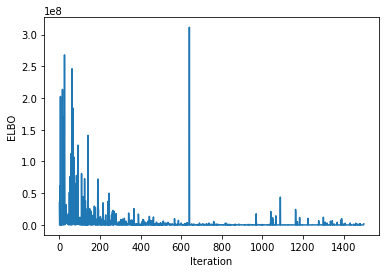

In [14]:
plot_elbo(elbo_hist)

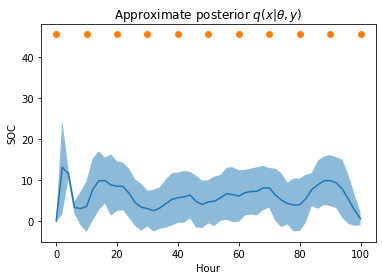

In [23]:
plot_post(net, q_theta, obs_model_CON_CO2, 0)

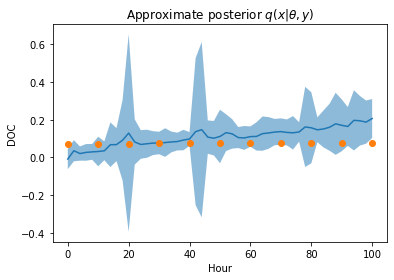

In [24]:
plot_post(net, q_theta, obs_model_CON_CO2, 1)

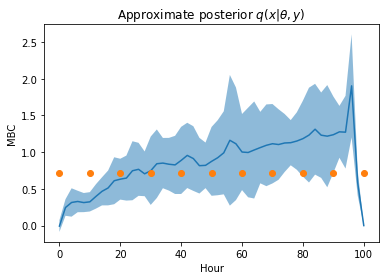

In [25]:
plot_post(net, q_theta, obs_model_CON_CO2, 2)

In [ ]:
plt.plot(torch.arange(1, n + 1), q_mean)
plt.fill_between(torch.arange(1, n + 1), q_mean - 2*q_std, q_mean + 2*q_std, alpha=0.5)
#plt.plot(q_mean - 2*q_std)
plt.plot(obs_model_CON_CO2.idx, obs_model_CON_CO2.mu[0, :], linestyle='None', marker='o')
plt.ylim((45.60, 45.70))

In [ ]:
plt.plot(elbo_hist[100:])

In [ ]:
plt.plot(elbo_hist1[100:])

In [ ]:
plt.plot(torch.arange(100, 9900), elbo_hist1[100:])

In [ ]:
len(elbo_hist1)

In [ ]:
min(3, 10)